In [84]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [85]:
DATA_DIR =r"D:\DESKTOP\AI proj\datasetage\Test\Test"
ANNOT_FILE =r"D:\DESKTOP\AI proj\datasetage\Train\Train"

In [86]:
df=pd.read_csv(r"D:\DESKTOP\AI proj\datasetage\sub.csv")
print(df.head())
print(df["Class"].describe())


    Class         ID
0  MIDDLE  25321.jpg
1   YOUNG    989.jpg
2  MIDDLE  19277.jpg
3  MIDDLE  13093.jpg
4  MIDDLE   5367.jpg
count       6636
unique         3
top       MIDDLE
freq        3834
Name: Class, dtype: object


In [87]:
df = pd.read_csv(r"D:\DESKTOP\AI proj\datasetage\sub.csv")
df.head(5)

# Define your label mapping
class_map = {"YOUNG": 0,"MIDDLE":1,"OLD": 2}

# Create a new numeric column
df["label"]=df["Class"].map(class_map)

# Quick sanity check
print(df["Class"].value_counts(), "\n")
print(df["label"].value_counts())


MIDDLE    3834
YOUNG     2138
OLD        664
Name: Class, dtype: int64 

1    3834
0    2138
2     664
Name: label, dtype: int64


In [88]:
# Build absolute paths to each image->
df["file_path"]=df["ID"].apply(lambda fn:os.path.join(DATA_DIR,fn))

#print(df["file_path"])
#print(df.columns)
# Extract numpy arrays
file_paths=df["file_path"].values
labels=df["label"].values


In [89]:
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths,labels,test_size=0.20,stratify=labels,random_state=0)

In [90]:
IMG_SIZE=(64,64)
BATCH_SIZE=12

def load_and_preprocess(path,label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img,IMG_SIZE)
    img = img / 255.0
    return img, label

train_ds = (
    tf.data.Dataset.from_tensor_slices((train_paths,train_labels))
      .shuffle(len(train_paths))
      .map(load_and_preprocess)
      .batch(BATCH_SIZE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_paths,val_labels))
      .map(load_and_preprocess)
      .batch(BATCH_SIZE)
)



In [91]:
num_classes = len(class_map)

model = models.Sequential([
    layers.Input((64, 64, 3)),
    
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 6, 6, 128)        

In [92]:
callbacks = [
    ModelCheckpoint(
        "age_classifier_imfdb.h5",
        save_best_only=True,
        monitor="val_accuracy",
        verbose=1
    ),
    EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor="val_loss",
        verbose=1
    ),
]


In [93]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=callbacks)



Epoch 1/50
443/443 [==============================] - ETA: 0s - loss: 0.8940 - accuracy: 0.5880
Epoch 1: val_accuracy improved from -inf to 0.66867, saving model to age_classifier_imfdb.h5
443/443 [==============================] - 43s 93ms/step - loss: 0.8940 - accuracy: 0.5880 - val_loss: 0.7817 - val_accuracy: 0.6687
Epoch 2/50


c:\miniconda\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


442/443 [============================>.] - ETA: 0s - loss: 0.7475 - accuracy: 0.6744
Epoch 2: val_accuracy improved from 0.66867 to 0.67922, saving model to age_classifier_imfdb.h5
443/443 [==============================] - 34s 77ms/step - loss: 0.7474 - accuracy: 0.6745 - val_loss: 0.7204 - val_accuracy: 0.6792
Epoch 3/50
442/443 [============================>.] - ETA: 0s - loss: 0.6986 - accuracy: 0.6966
Epoch 3: val_accuracy improved from 0.67922 to 0.69352, saving model to age_classifier_imfdb.h5
443/443 [==============================] - 27s 60ms/step - loss: 0.6981 - accuracy: 0.6969 - val_loss: 0.7168 - val_accuracy: 0.6935
Epoch 4/50
442/443 [============================>.] - ETA: 0s - loss: 0.6695 - accuracy: 0.7136
Epoch 4: val_accuracy improved from 0.69352 to 0.72063, saving model to age_classifier_imfdb.h5
443/443 [==============================] - 25s 57ms/step - loss: 0.6696 - accuracy: 0.7136 - val_loss: 0.6818 - val_accuracy: 0.7206
Epoch 5/50
443/443 [================

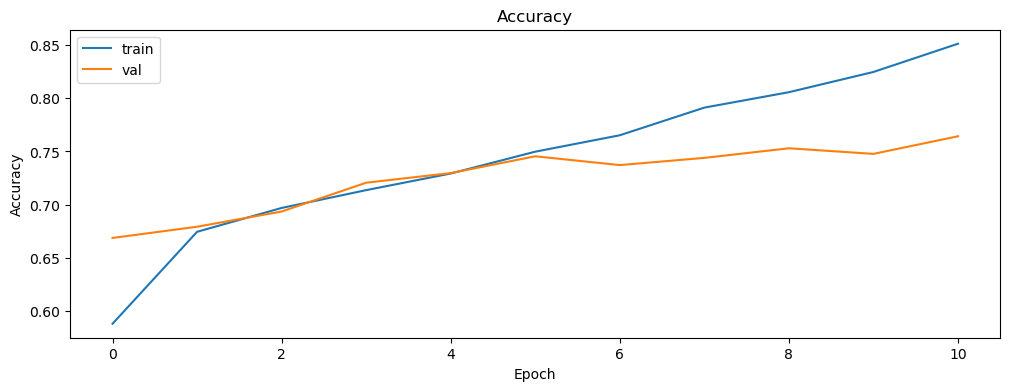

In [99]:
plt.figure(figsize=(12,4))

# Accuracy
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [98]:
model_save_path = r"D:\DESKTOP\AI proj\project\models\age_classifier_imfdb.h5"
model.save(model_save_path)



c:\miniconda\envs\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
